# Setup, matplotlib inline, automatically reload libraries on every evaluation

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from creon.loadcreon import LoadCreon, load_search, save_search
from creon.creonsklearn.creonmetrics import pu_scorer, prior_squared_error_scorer_015, brier_score_labeled_loss_scorer, \
    f1_assumed_scorer, f1_labeled_scorer, report_metrics, f1_assumed_beta10_scorer, pu_mix_assumed_f1beta10_scorer
from creon.semisuperhelper import SemiSupervisedHelper
from creon.creonsklearn.pnuwrapper import PNUWrapper
from creon.creonsklearn.jeffsearchcv import JeffRandomSearchCV, extract_score_grid
from creon.creonsklearn.nestedcross import NestedCV
from creon.creonsklearn.frankenscorer import FrankenScorer, extract_scores_from_nested
from creon.creonsklearn.repeatedsampling import RepeatedRandomSubSampler

In [3]:
path = "C:\Data\\010317\membership14_final_0103.txt"
lc = LoadCreon(path)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.base import clone

In [5]:
X_train, X_test, y_train, y_test = train_test_split(lc.X, lc.y, test_size=0.2, random_state=771, stratify=lc.y)

# FIRST REPEATED SUB SAMPLER

## Set up PNU Wrapper with Random Forest, then JeffSearchCV, then NestedCV

In [6]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
rep = RepeatedRandomSubSampler(base_estimator=rf, verbose=1)
pnu = PNUWrapper(base_estimator=rep, num_unlabeled=1.0)

## Set up randomized search parameters

In [7]:
rf_param_search = {'base_estimator__base_estimator':[rf, et],
 'base_estimator__base_estimator__bootstrap': [True, False],
 'base_estimator__base_estimator__class_weight': [None,'balanced','balanced_subsample'],
 'base_estimator__base_estimator__criterion': ['gini','entropy'],
 'base_estimator__base_estimator__max_depth': [None] + list(range(2,100)),
 'base_estimator__base_estimator__max_features': ['sqrt','log2',None] + list(range(5,100)),
 'base_estimator__base_estimator__min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100],
 'base_estimator__base_estimator__min_samples_split':[2,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,
                                                        0.045,0.05,0.07,0.09,0.1,0.12,0.15,0.17,0.2,0.25],
 'base_estimator__base_estimator__n_estimators': sp.stats.randint(low=10, high=300),
 'base_estimator__sample_imbalance': sp.stats.uniform(loc=0.1, scale=0.9),
 'pu_learning': [True, False]
                  }

### notice random_state is set in jeffsearch, this is so that the same random parameters are searched for each outer fold, sort of like grid search

In [8]:
jeffsearch = JeffRandomSearchCV(pnu, rf_param_search, n_iter=60, scoring=FrankenScorer(decision_score='assumed_f1beta10'),
                                n_jobs=-1, cv=3, verbose=1, pre_dispatch=8, random_state=77)

#### 3x3 (x60) nested cross validation

In [9]:
nested_cross = NestedCV(jeffsearch, scoring=FrankenScorer(decision_score='assumed_f1beta10'), cv=3, random_state=None)

## Score the nested cross

In [10]:
scores = nested_cross.score(X_train.values, y=y_train.values, verbose=100, pre_dispatch=8)

[CV]  ................................................................
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 112.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 489.4min finished


generating 137 samples of indices to use to train multiple estimators,               sized 2830 elements with last being 1524 elements


[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed: 15.6min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed: 15.6min finished


[CV]  , score=0.702562296381 score_data={'labeled_acc': 0.82011834319526622, 'assumed_f1beta10': 0.70256229638108647, 'assumed_brier_neg': 0.095473052356552665, 'labeled_brier_pos': 0.16992182157136196, 'assumed_brier': 0.095825911141888376, 'labeled_roc_auc': 0.80570204967085568, 'pu_score': 6.8401854874045922, 'pr_one_unlabeled': 0.10198414398971502, 'confusion_matrix_un': array([[104995,  11968],
       [    83,    474]]), 'labeled_f1': 0.86181818181818171, 'labeled_brier': 0.17982954499036324, 'confusion_matrix_lab': array([[219,  69],
       [ 83, 474]]), 'assumed_f1': 0.072928686822063243, 'labeled_prec': 0.8729281767955801, 'labeled_brier_neg': 0.19899135729725112, 'SCORE': 0.70256229638108647, 'labeled_recall': 0.85098743267504484, 'labeled_avg_prec': 0.9110702307708155}, total=505.9min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 537.2min remaining:    0.0s
[CV]  ................................................................
Fitting 3 folds for each of 60 candidates,

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 117.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 529.8min finished


generating 137 samples of indices to use to train multiple estimators,               sized 2830 elements with last being 1525 elements


[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  7.4min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  7.4min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed: 15.3min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed: 15.4min finished


[CV]  , score=0.70122764265 score_data={'labeled_acc': 0.81872037914691942, 'assumed_f1beta10': 0.70122764265023685, 'assumed_brier_neg': 0.074222194234285888, 'labeled_brier_pos': 0.14428425002048584, 'assumed_brier': 0.074554264495885439, 'labeled_roc_auc': 0.82127687524631066, 'pu_score': 8.141926515967004, 'pr_one_unlabeled': 0.077523034068995078, 'confusion_matrix_un': array([[107868,   9094],
       [   104,    453]]), 'labeled_f1': 0.85552407932011321, 'labeled_brier': 0.14973095356007535, 'confusion_matrix_lab': array([[238,  49],
       [104, 453]]), 'assumed_f1': 0.089667458432304017, 'labeled_prec': 0.90239043824701193, 'labeled_brier_neg': 0.16030173360032404, 'SCORE': 0.70122764265023685, 'labeled_recall': 0.81328545780969475, 'labeled_avg_prec': 0.91944932243593624}, total=548.9min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 1116.8min remaining:    0.0s
[CV]  ................................................................
Fitting 3 folds for each of 60 candidate

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 118.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 564.8min finished


generating 137 samples of indices to use to train multiple estimators,               sized 2833 elements with last being 1255 elements


[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  7.4min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed: 15.4min finished
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed: 15.4min finished


[CV]  , score=0.707446235318 score_data={'labeled_acc': 0.83867141162514824, 'assumed_f1beta10': 0.70744623531766204, 'assumed_brier_neg': 0.073830485701749118, 'labeled_brier_pos': 0.13907766980805419, 'assumed_brier': 0.074139185161087792, 'labeled_roc_auc': 0.8481970521144061, 'pu_score': 8.4090020631052518, 'pr_one_unlabeled': 0.076015221900337687, 'confusion_matrix_un': array([[108057,   8904],
       [   101,    455]]), 'labeled_f1': 0.86998087954110903, 'labeled_brier': 0.1389149549523232, 'confusion_matrix_lab': array([[252,  35],
       [101, 455]]), 'assumed_f1': 0.091780131114473015, 'labeled_prec': 0.9285714285714286, 'labeled_brier_neg': 0.13859973035376419, 'SCORE': 0.70744623531766204, 'labeled_recall': 0.81834532374100721, 'labeled_avg_prec': 0.93336347698658562}, total=584.0min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 1731.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 1731.7min finished


## The scores of the 3 folds of the outer loop

In [14]:
scores

(0.70256229638108647, 0.70122764265023685, 0.70744623531766204)

In [12]:
save_search(nested_cross, './res/nested_cross_repreated_rf_large_20170131.pkl')

In [96]:
nested_cross = load_search('./res/nested_cross_repreated_rf_large_20170131.pkl')

In [5]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean().sort_index()

assumed_brier                                                      0.0815065
assumed_brier_neg                                                  0.0811752
assumed_f1                                                         0.0847921
assumed_f1beta10                                                    0.703745
confusion_matrix_lab          [[236.333333333, 51.0], [96.0, 460.666666667]]
confusion_matrix_un        [[106973.333333, 9988.66666667], [96.0, 460.66...
fn_confusion_matrix_lab                                                   96
fn_confusion_matrix_un                                                    96
fp_confusion_matrix_lab                                                   51
fp_confusion_matrix_un                                               9988.67
labeled_acc                                                         0.825837
labeled_avg_prec                                                    0.921294
labeled_brier                                                       0.156158

In [10]:
[est.best_index_ for est in nested_cross.estimators_]

[57, 57, 57]

In [6]:
t = extract_score_grid(nested_cross.estimators_[0])
t['optimize_score'] = t.mean_pu_score_test + (t.mean_assumed_f1beta10_test * 100)
t[['mean_pu_score_test','mean_assumed_f1beta10_test','optimize_score','mean_pr_one_unlabeled_test']].iloc[34]

mean_pu_score_test            11.311659
mean_assumed_f1beta10_test     0.689577
optimize_score                80.269381
mean_pr_one_unlabeled_test     0.046951
Name: 34, dtype: float64

## Let's rescore for estimator 34, looks a little better than 57 based on PU + f1beta10

In [7]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
rep_test = RepeatedRandomSubSampler(base_estimator=rf, voting='thresh', verbose=1, random_state=83)
pnu_test = PNUWrapper(base_estimator=rep_test, num_unlabeled=1.0)
pnu_test.set_params(**{'base_estimator__base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=64, max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, n_jobs=-1, oob_score=False, random_state=324,
              verbose=0, warm_start=False),
  'base_estimator__base_estimator__bootstrap': False,
  'base_estimator__base_estimator__class_weight': None,
  'base_estimator__base_estimator__criterion': 'gini',
  'base_estimator__base_estimator__max_depth': 64,
  'base_estimator__base_estimator__max_features': 87,
  'base_estimator__base_estimator__min_samples_leaf': 8,
  'base_estimator__base_estimator__min_samples_split': 0.01,
  'base_estimator__base_estimator__n_estimators': 79,
  'base_estimator__sample_imbalance': 0.44063408204723742,
  'pu_learning': True})

PNUWrapper(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=64, max_features=87, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=0.01, min_weight...      random_state=83, sample_imbalance=0.4406340820472374,
             verbose=1, voting='thresh'),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [100]:
from nestedcross import rerun_nested_for_estimator

In [101]:
nested_cross = rerun_nested_for_estimator(nested_cross, pnu_test, X_train.values, y_train.values, n_jobs=-1)

In [392]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean().sort_index()

assumed_brier                                                       0.047308
assumed_brier_neg                                                  0.0468077
assumed_f1                                                          0.114702
assumed_f1beta10                                                    0.717183
confusion_matrix_lab         [[248.333333333, 39.0], [110.0, 446.666666667]]
confusion_matrix_un        [[110173.666667, 6788.33333333], [110.0, 446.6...
fn_confusion_matrix_lab                                                  110
fn_confusion_matrix_un                                                   110
fp_confusion_matrix_lab                                                   39
fp_confusion_matrix_un                                               6788.33
labeled_acc                                                         0.823463
labeled_avg_prec                                                    0.926313
labeled_brier                                                        0.14321

In [395]:
extract_scores_from_nested(nested_cross.test_score_datas_).std().sort_index()

assumed_brier                0.001065
assumed_brier_neg            0.001118
assumed_f1                   0.002403
assumed_f1beta10             0.010416
fn_confusion_matrix_lab      8.000000
fn_confusion_matrix_un       8.000000
fp_confusion_matrix_lab      7.549834
fp_confusion_matrix_un     261.582364
labeled_acc                  0.010044
labeled_avg_prec             0.006516
labeled_brier                0.006637
labeled_brier_neg            0.013219
labeled_brier_pos            0.010171
labeled_f1                   0.008439
labeled_prec                 0.013733
labeled_recall               0.014364
labeled_roc_auc              0.012070
pr_one_unlabeled             0.002187
pu_mix_assumed_f1beta10      1.148760
pu_score                     0.224291
tn_confusion_matrix_lab      7.094599
tn_confusion_matrix_un     260.672847
tp_confusion_matrix_lab      8.020806
tp_confusion_matrix_un       8.020806
dtype: float64

# Let's dive in and see the parameters for one of the best models

In [43]:
[est.cv_results_['params'][34] for est in nested_cross.estimators_]

[{'base_estimator__base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=64, max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
              verbose=0, warm_start=False),
  'base_estimator__base_estimator__bootstrap': False,
  'base_estimator__base_estimator__class_weight': None,
  'base_estimator__base_estimator__criterion': 'gini',
  'base_estimator__base_estimator__max_depth': 64,
  'base_estimator__base_estimator__max_features': 87,
  'base_estimator__base_estimator__min_samples_leaf': 8,
  'base_estimator__base_estimator__min_samples_split': 0.01,
  'base_estimator__base_estimator__n_estimators': 79,
  'base_estimator__sample_imbalance': 0.44063408204723742,
  'pu_learning': True},
 {'base_estimator__base_estimator': RandomFores

## Let's see what feature importance looks like for this specific estimator

In [20]:
feature_importances = np.array([est.best_estimator_.feature_importances_ for est in nested_cross.estimators_])

In [21]:
feature_importance = np.mean(feature_importances, axis=0)

In [23]:
cc = X_test.columns.values
cc = np.insert(cc, 109, ['CPT_FLAG44_Sum'])
len(cc)

288

In [24]:
X_test.columns[X_test.columns.str.contains('CPT')]

Index(['CPT_FLAG1_Sum', 'CPT_FLAG2_Sum', 'CPT_FLAG3_Sum', 'CPT_FLAG4_Sum',
       'CPT_FLAG5_Sum', 'CPT_FLAG6_Sum', 'CPT_FLAG7_Sum', 'CPT_FLAG8_Sum',
       'CPT_FLAG9_Sum', 'CPT_FLAG10_Sum', 'CPT_FLAG11_Sum', 'CPT_FLAG12_Sum',
       'CPT_FLAG13_Sum', 'CPT_FLAG14_Sum', 'CPT_FLAG15_Sum', 'CPT_FLAG16_Sum',
       'CPT_FLAG17_Sum', 'CPT_FLAG18_Sum', 'CPT_FLAG19_Sum', 'CPT_FLAG20_Sum',
       'CPT_FLAG21_Sum', 'CPT_FLAG22_Sum', 'CPT_FLAG26_Sum', 'CPT_FLAG29_Sum',
       'CPT_FLAG32_Sum', 'CPT_FLAG33_Sum', 'CPT_FLAG34_Sum', 'CPT_FLAG35_Sum',
       'CPT_FLAG36_Sum', 'CPT_FLAG37_Sum', 'CPT_FLAG43_Sum', 'CPT_FLAG45_Sum',
       'CPT_FLAG46_Sum', 'CPT_FLAG47_Sum', 'CPT_FLAG48_Sum', 'CPT_FLAG49_Sum'],
      dtype='object')

In [25]:
c = pd.DataFrame(list(enumerate(cc)))
c[c[1].str.contains('CPT')]

,0,1
78,78,CPT_FLAG1_Sum
79,79,CPT_FLAG2_Sum
80,80,CPT_FLAG3_Sum
81,81,CPT_FLAG4_Sum
82,82,CPT_FLAG5_Sum
83,83,CPT_FLAG6_Sum
84,84,CPT_FLAG7_Sum
85,85,CPT_FLAG8_Sum
86,86,CPT_FLAG9_Sum
87,87,CPT_FLAG10_Sum


In [44]:
importance = pd.DataFrame(feature_importance, index=cc, columns=['Importance']).sort_values(by='Importance', ascending=False)
importance.round(5) * 100

,Importance
DIAG_FLAG4_Sum,33.557
DIAG_FLAG5_Sum,20.414
ndc_cat58_Sum,6.526
CPT_FLAG9_Sum,4.300
ndc_cat87_Sum,3.695
DIAG_FLAG75_Sum,3.290
ndc_cat54_Sum,1.936
CPT_FLAG43_Sum,1.368
DIAG_FLAG42_Sum,1.265
age,1.173


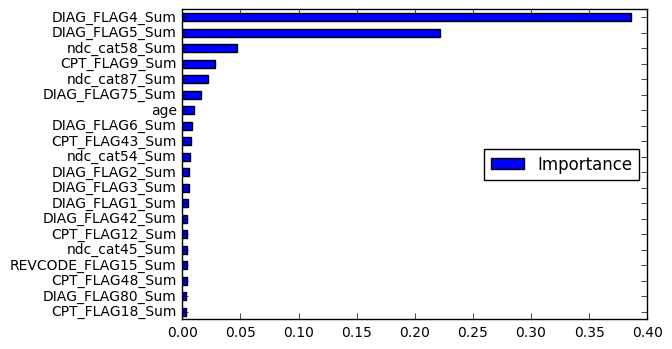

In [46]:
ax = importance.iloc[:20].iloc[::-1].plot(kind='barh')
ax.legend(loc='right')

## This is model 6 in draft, lets retrain on whole training set and then test on test set!

In [8]:
pnu_test.fit(X_train.values, y_train.values)

generating 93 samples of indices to use to train multiple estimators, sized 5459 elements with last being 3106 elements


[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   24.6s finished


PNUWrapper(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=64, max_features=87, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=0.01, min_weight...      random_state=83, sample_imbalance=0.4406340820472374,
             verbose=1, voting='thresh'),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [9]:
FrankenScorer()(pnu_test, X_test.values, y_test.values)

[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   17.3s finished
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   17.3s finished


({'SCORE': 0.8524173027989822,
  'assumed_brier': 0.047122284684122738,
  'assumed_brier_neg': 0.046674723431473317,
  'assumed_f1': 0.11621856027753687,
  'assumed_f1beta10': 0.71764905508303811,
  'confusion_matrix_lab': array([[182,  33],
         [ 83, 335]]),
  'confusion_matrix_un': array([[82710,  5012],
         [   83,   335]]),
  'labeled_acc': 0.81674565560821488,
  'labeled_avg_prec': 0.92144156831253521,
  'labeled_brier': 0.13823256482643567,
  'labeled_brier_neg': 0.13275874573143373,
  'labeled_brier_pos': 0.14104804593989362,
  'labeled_f1': 0.8524173027989822,
  'labeled_prec': 0.91032608695652173,
  'labeled_recall': 0.80143540669856461,
  'labeled_roc_auc': 0.82397351730277069,
  'pr_one_unlabeled': 0.056898305278434869,
  'pu_mix_assumed_f1beta10': 82.352563708648617,
  'pu_score': 10.587658200344801},
 0.8524173027989822)

In [29]:
pnu_test.base_estimator.voting = 'soft'

In [30]:
FrankenScorer()(pnu_test, X_test.values, y_test.values)

[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   51.5s finished
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   51.0s finished


({'SCORE': 0.85133418043202036,
  'assumed_brier': 0.046065131103342795,
  'assumed_brier_neg': 0.045624730612820928,
  'assumed_f1': 0.11885754834131629,
  'assumed_f1beta10': 0.7196027137965505,
  'confusion_matrix_lab': array([[181,  34],
         [ 83, 335]]),
  'confusion_matrix_un': array([[82838,  4884],
         [   83,   335]]),
  'labeled_acc': 0.81516587677725116,
  'labeled_avg_prec': 0.92020806412966749,
  'labeled_brier': 0.13710769055497413,
  'labeled_brier_neg': 0.13442386739787418,
  'labeled_brier_pos': 0.13848812591089871,
  'labeled_f1': 0.85133418043202036,
  'labeled_prec': 0.90785907859078596,
  'labeled_recall': 0.80143540669856461,
  'labeled_roc_auc': 0.82164793590742191,
  'pr_one_unlabeled': 0.055424137497571621,
  'pu_mix_assumed_f1beta10': 82.807600062782797,
  'pu_score': 10.847328683127737},
 0.85133418043202036)

In [233]:
pnu_test.base_estimator.voting = 'thresh'
pnu_test.base_estimator.binary_thresh = 0.8

In [234]:
FrankenScorer()(pnu_test, X_test.values, y_test.values)

[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   50.9s finished
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   51.0s finished


({'SCORE': 0.7780898876404494,
  'assumed_brier': 0.046065131103342795,
  'assumed_brier_neg': 0.045624730612820928,
  'assumed_f1': 0.21423047177107499,
  'assumed_f1beta10': 0.6363036754002912,
  'confusion_matrix_lab': array([[198,  17],
         [141, 277]]),
  'confusion_matrix_un': array([[85831,  1891],
         [  141,   277]]),
  'labeled_acc': 0.75039494470774093,
  'labeled_avg_prec': 0.91380255587574832,
  'labeled_brier': 0.13710769055497413,
  'labeled_brier_neg': 0.13442386739787418,
  'labeled_brier_pos': 0.13848812591089871,
  'labeled_f1': 0.7780898876404494,
  'labeled_prec': 0.94217687074829937,
  'labeled_recall': 0.66267942583732053,
  'labeled_roc_auc': 0.79180482919772999,
  'pr_one_unlabeled': 0.021415429622773034,
  'pu_mix_assumed_f1beta10': 81.48375962889952,
  'pu_score': 17.853392088870407},
 0.7780898876404494)

In [237]:
pnu_test.base_estimator.voting = 'thresh'
pnu_test.base_estimator.binary_thresh = 0.35

In [238]:
FrankenScorer()(pnu_test, X_test.values, y_test.values)

[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   51.2s finished
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   51.1s finished


({'SCORE': 0.86134969325153377,
  'assumed_brier': 0.046065131103342795,
  'assumed_brier_neg': 0.045624730612820928,
  'assumed_f1': 0.096085409252669035,
  'assumed_f1beta10': 0.72812602694709172,
  'confusion_matrix_lab': array([[169,  46],
         [ 67, 351]]),
  'confusion_matrix_un': array([[81185,  6537],
         [   67,   351]]),
  'labeled_acc': 0.82148499210110582,
  'labeled_avg_prec': 0.91484454135130533,
  'labeled_brier': 0.13710769055497413,
  'labeled_brier_neg': 0.13442386739787418,
  'labeled_brier_pos': 0.13848812591089871,
  'labeled_f1': 0.86134969325153377,
  'labeled_prec': 0.88413098236775822,
  'labeled_recall': 0.83971291866028708,
  'labeled_roc_auc': 0.81287971514409696,
  'pr_one_unlabeled': 0.074176922989018026,
  'pu_mix_assumed_f1beta10': 81.835407810464858,
  'pu_score': 9.0228051157556823},
 0.86134969325153377)

In [239]:
pnu_test.base_estimator.voting = 'thresh'
pnu_test.base_estimator.binary_thresh = 0.40

In [240]:
FrankenScorer()(pnu_test, X_test.values, y_test.values)

[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   51.2s finished
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   51.0s finished


({'SCORE': 0.8635235732009926,
  'assumed_brier': 0.046065131103342795,
  'assumed_brier_neg': 0.045624730612820928,
  'assumed_f1': 0.10606522401706797,
  'assumed_f1beta10': 0.73310528950442189,
  'confusion_matrix_lab': array([[175,  40],
         [ 70, 348]]),
  'confusion_matrix_un': array([[81926,  5796],
         [   70,   348]]),
  'labeled_acc': 0.82622432859399686,
  'labeled_avg_prec': 0.92001380991488291,
  'labeled_brier': 0.13710769055497413,
  'labeled_brier_neg': 0.13442386739787418,
  'labeled_brier_pos': 0.13848812591089871,
  'labeled_f1': 0.8635235732009926,
  'labeled_prec': 0.89690721649484539,
  'labeled_recall': 0.83253588516746413,
  'labeled_roc_auc': 0.82324468676977869,
  'pr_one_unlabeled': 0.065777594935262321,
  'pu_mix_assumed_f1beta10': 83.253765318943366,
  'pu_score': 9.9432363685011786},
 0.8635235732009926)

In [396]:
pnu_test.base_estimator.voting = 'thresh'
pnu_test.base_estimator.binary_thresh = 0.20

In [397]:
FrankenScorer()(pnu_test, X_test.values, y_test.values)

[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   51.2s finished
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   51.3s finished


({'SCORE': 0.85049833887043191,
  'assumed_brier': 0.046065131103342795,
  'assumed_brier_neg': 0.045624730612820928,
  'assumed_f1': 0.052494873547505122,
  'assumed_f1beta10': 0.6924230522030993,
  'confusion_matrix_lab': array([[114, 101],
         [ 34, 384]]),
  'confusion_matrix_un': array([[73894, 13828],
         [   34,   384]]),
  'labeled_acc': 0.78672985781990523,
  'labeled_avg_prec': 0.88206267232684588,
  'labeled_brier': 0.13710769055497413,
  'labeled_brier_neg': 0.13442386739787418,
  'labeled_brier_pos': 0.13848812591089871,
  'labeled_f1': 0.85049833887043191,
  'labeled_prec': 0.79175257731958759,
  'labeled_recall': 0.91866028708133973,
  'labeled_roc_auc': 0.72444642261043724,
  'pr_one_unlabeled': 0.15686745060395169,
  'pu_mix_assumed_f1beta10': 74.47623308201419,
  'pu_score': 5.2339278617042622},
 0.85049833887043191)

# Feature importance for 80/20

In [10]:
importance = pd.DataFrame(pnu_test.feature_importances_, index=X_test.columns.values, columns=['Importance']).sort_values(by='Importance', ascending=False)
importance.round(5) * 100

,Importance
DIAG_FLAG4_Sum,39.730
DIAG_FLAG5_Sum,28.037
ndc_cat58_Sum,6.044
DIAG_FLAG75_Sum,3.189
ndc_cat87_Sum,2.990
CPT_FLAG9_Sum,1.804
age,1.128
ndc_cat54_Sum,0.869
DIAG_FLAG6_Sum,0.783
CPT_FLAG43_Sum,0.482


In [13]:
importance.loc['DIAG_FLAG53_Sum']

Importance    0.001582
Name: DIAG_FLAG53_Sum, dtype: float64

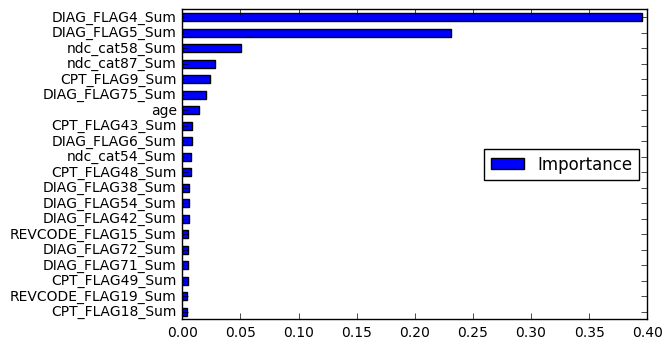

In [32]:
ax = importance.iloc[:20].iloc[::-1].plot(kind='barh')
ax.legend(loc='right')

# Probability distribution of the 20%

In [70]:
pnu_test.base_estimator.voting = 'soft'

In [41]:
probas = pnu_test.predict_proba(X_test)[:, -1]

[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   17.3s finished


In [42]:
probas_df = pd.DataFrame(data={'probas':probas, 'y_test':y_test.values}).sort_values(by='probas', ascending=False)

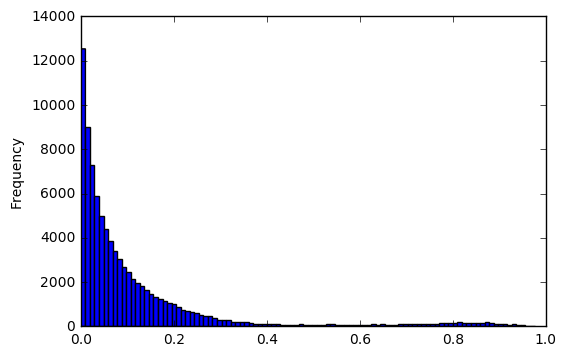

In [126]:
probas_df['probas'].plot.hist(bins=100)

In [127]:
bins = np.linspace(0.0, 1.0, 101)
percent = pd.cut(probas_df['probas'], bins=bins, include_lowest=True, precision=6, labels=list(range(0,100)))
probas_df['percent'] = percent

In [216]:
bins5 = np.linspace(0.0, 1.0, 21)
percent5 = pd.cut(probas_df['probas'], right=True, bins=bins5, include_lowest=True, precision=6, 
                  labels=['0%-5%','5%-10%','10%-15%','15%-20%','20%-25%','25%-30%','30%-35%','35%-40%','40%-45%','45%-50%',
                          '50%-55%','55%-60%','60%-65%','65%-70%','70%-75%','75%-80%','80%-85%','85%-90%','90%-95%',
                          '95%-100%'])
probas_df['percent5'] = percent5

In [75]:
probas_df.to_csv('./res/predicted_probabilities_soft.csv')

In [217]:
probas_df.head()

,probas,y_test,percent5
72609,0.975608,-1,95%-100%
73802,0.975383,-1,95%-100%
342,0.975339,1,95%-100%
8513,0.972576,1,95%-100%
17976,0.971195,-1,95%-100%


In [218]:
dummies = pd.get_dummies(probas_df['y_test'], prefix='y=', prefix_sep='')

In [219]:
probas_df = pd.concat([probas_df, dummies], axis=1)

In [220]:
probas_group = probas_df.groupby('percent5')

In [221]:
percentile_df = probas_group.aggregate({'probas':'count', 'y=-1':'sum', 'y=0':'sum', 'y=1':'sum'})

In [222]:
percentile_df.head()

,probas,y=1,y=0,y=-1
percent5,,,,
0%-5%,40329,6,29,40294.0
5%-10%,17409,9,29,17371.0
10%-15%,9934,6,27,9901.0
15%-20%,6256,13,29,6214.0
20%-25%,3801,9,20,3772.0


In [223]:
labeled_tot = percentile_df['y=1'] + percentile_df['y=0']
percentile_df['unlabeled_pct'] = percentile_df['y=-1'] / percentile_df.probas
percentile_df['true_pos_pct'] = percentile_df['y=1'] / labeled_tot
percentile_df['true_neg_pct'] = percentile_df['y=0'] / labeled_tot

In [224]:
percentile_df

,probas,y=1,y=0,y=-1,unlabeled_pct,true_pos_pct,true_neg_pct
percent5,,,,,,,
0%-5%,40329,6,29,40294.0,0.999132,0.171429,0.828571
5%-10%,17409,9,29,17371.0,0.997817,0.236842,0.763158
10%-15%,9934,6,27,9901.0,0.996678,0.181818,0.818182
15%-20%,6256,13,29,6214.0,0.993286,0.309524,0.690476
20%-25%,3801,9,20,3772.0,0.992370,0.310345,0.689655
25%-30%,2294,9,22,2263.0,0.986486,0.290323,0.709677
30%-35%,1229,15,13,1201.0,0.977217,0.535714,0.464286
35%-40%,744,3,6,735.0,0.987903,0.333333,0.666667
40%-45%,505,6,5,494.0,0.978218,0.545455,0.454545


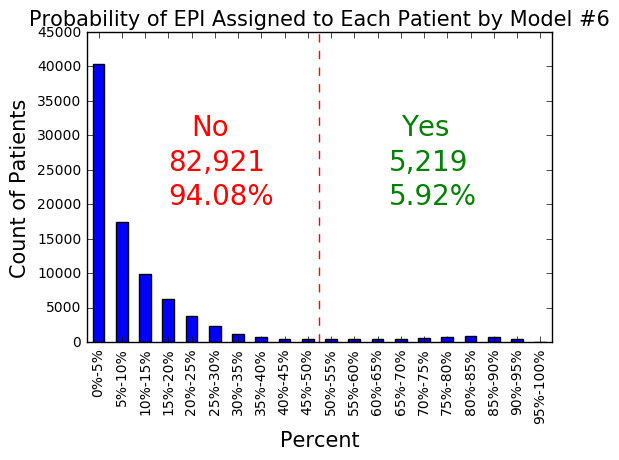

In [227]:
ax = percentile_df.probas.plot(kind='bar')
ax.set_title("Probability of EPI Assigned to Each Patient by Model #6", fontsize=15)
ax.set_xlabel("Percent", fontsize=15)
ax.set_ylabel("Count of Patients", fontsize=15)
ax.axvline(x=9.5, ls='--', c='r')
ax.text(4, 30000, "No", fontsize=20, color='red')
ax.text(3, 25000, "82,921", fontsize=20, color='red')
ax.text(3, 20000, "94.08%", fontsize=20, color='red')
ax.text(13, 30000, "Yes", fontsize=20, color='green')
ax.text(12.5, 25000, "5,219", fontsize=20, color='green')
ax.text(12.5, 20000, "5.92%", fontsize=20, color='green')

In [84]:
percentile_df.to_csv('./res/percentage_table_soft.csv')

In [171]:
tot = percentile_df.probas.sum()
percentile_df['pct_of_total'] = percentile_df.probas / tot

In [172]:
percentile_df['cum_pct_of_total'] = percentile_df.pct_of_total.cumsum()

In [173]:
percentile_df = percentile_df.ffill()

In [174]:
tp = np.polyfit(x=percentile_df.index.values.astype(int), y=percentile_df.true_pos_pct, deg=1)
tpp = np.poly1d(tp)
percentile_df['tp_trendline'] = tpp(percentile_df.index.values.astype(int))

ValueError: invalid literal for int() with base 10: '[0, 0.05]'

In [ ]:
tn = np.polyfit(x=percentile_df.index.values.astype(int), y=percentile_df.true_neg_pct, deg=1)
tnp = np.poly1d(tn)
percentile_df['tn_trendline'] = tnp(percentile_df.index.values.astype(int))

In [90]:
import matplotlib.pyplot as plt

In [91]:
df = percentile_df
x_axis = df.index.values.astype(int)

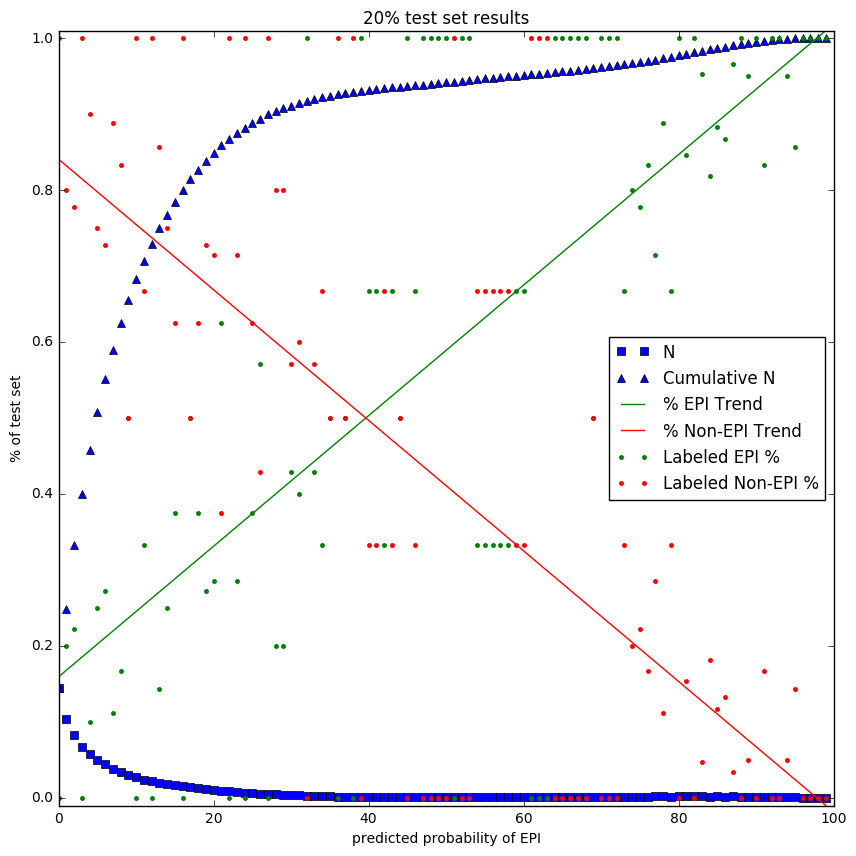

In [92]:
plt.figure(figsize=(10,10))
plt.plot(x_axis, df.pct_of_total, 'bs', label='N')
plt.plot(x_axis, df.cum_pct_of_total, 'b^', label='Cumulative N')
plt.plot(x_axis, df.tp_trendline, 'g-', label='% EPI Trend')
plt.plot(x_axis, df.tn_trendline, 'r-', label='% Non-EPI Trend')
plt.plot(x_axis, df.true_pos_pct, 'g.', label='Labeled EPI %')
plt.plot(x_axis, df.true_neg_pct, 'r.', label='Labeled Non-EPI %')
plt.axis([0, 100, -0.01, 1.01])
plt.ylabel('% of test set')
plt.xlabel('predicted probability of EPI')
plt.title('20% test set results')
plt.legend(loc='right')

In [95]:
sum(probas>=0.5)

5219

# learning curve

In [8]:
from sklearn.model_selection import learning_curve

In [10]:
pnu_test.set_params(**{'base_estimator__n_jobs':-1})

PNUWrapper(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=64, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weigh...obs', random_state=None,
             sample_imbalance=0.4406340820472374, verbose=1, voting='hard'),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [20]:
train_sizes, train_scores, test_scores = learning_curve(pnu_test, X_train.values, 
                                                        y_train.values, 
                                                        train_sizes=np.asarray([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
                                                        n_jobs=1, verbose=10,
                                                        scoring=pu_mix_assumed_f1beta10_scorer)

[learning_curve] Training set sizes: [ 11751  23503  47007  70510  94014 117518 141021 164525 188028 211532
 235036]
[CV]  ................................................................
generating 119 samples of indices to use to train multiple estimators, sized 143 elements with last being 59 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:    9.0s finished


[CV] ................................ , score=61.152539, total= 1.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


generating 108 samples of indices to use to train multiple estimators, sized 313 elements with last being 244 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   15.5s finished


[CV] ................................ , score=73.422493, total= 1.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s


generating 98 samples of indices to use to train multiple estimators, sized 689 elements with last being 539 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   32.3s finished


[CV] ................................ , score=80.470246, total= 1.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.5min remaining:    0.0s


generating 99 samples of indices to use to train multiple estimators, sized 1023 elements with last being 763 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   48.2s finished


[CV] ................................ , score=81.920278, total= 1.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.9min remaining:    0.0s


generating 99 samples of indices to use to train multiple estimators, sized 1369 elements with last being 690 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.1min finished


[CV] ................................ , score=82.546836, total= 1.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.7min remaining:    0.0s


generating 96 samples of indices to use to train multiple estimators, sized 1755 elements with last being 1530 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   16.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.3min finished


[CV] ................................ , score=83.279343, total= 1.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 13.7min remaining:    0.0s


generating 96 samples of indices to use to train multiple estimators, sized 2112 elements with last being 1406 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   19.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.7min finished


[CV] ................................ , score=83.338492, total= 1.7min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 17.2min remaining:    0.0s


[CV]  ................................................................
generating 95 samples of indices to use to train multiple estimators, sized 2497 elements with last being 1221 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   21.9s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  2.0min finished


[CV] ................................ , score=83.918805, total= 1.8min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 20.9min remaining:    0.0s


[CV]  ................................................................
generating 98 samples of indices to use to train multiple estimators, sized 2749 elements with last being 2493 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   24.9s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  2.3min finished


[CV] ................................ , score=83.908591, total= 1.9min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 25.2min remaining:    0.0s


generating 95 samples of indices to use to train multiple estimators, sized 3190 elements with last being 2897 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   28.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  2.6min finished


[CV] ................................ , score=83.608365, total= 1.9min
[CV]  ................................................................
generating 93 samples of indices to use to train multiple estimators, sized 3638 elements with last being 2162 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   31.2s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  2.8min finished


[CV] ................................ , score=83.577889, total= 2.0min
[CV]  ................................................................
generating 90 samples of indices to use to train multiple estimators, sized 189 elements with last being 65 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.1s finished


[CV] ................................ , score=60.451023, total= 1.2min
[CV]  ................................................................
generating 93 samples of indices to use to train multiple estimators, sized 362 elements with last being 351 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   14.0s finished


[CV] ................................ , score=76.027128, total= 1.3min
[CV]  ................................................................
generating 92 samples of indices to use to train multiple estimators, sized 732 elements with last being 665 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:   31.0s finished


[CV] ................................ , score=78.564820, total= 1.4min
[CV]  ................................................................
generating 91 samples of indices to use to train multiple estimators, sized 1111 elements with last being 947 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   44.5s finished


[CV] ................................ , score=80.079050, total= 1.5min
[CV]  ................................................................
generating 94 samples of indices to use to train multiple estimators, sized 1445 elements with last being 513 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:  1.0min finished


[CV] ................................ , score=80.365678, total= 1.6min
[CV]  ................................................................
generating 93 samples of indices to use to train multiple estimators, sized 1821 elements with last being 944 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  1.3min finished


[CV] ................................ , score=81.018526, total= 1.6min
[CV]  ................................................................
generating 96 samples of indices to use to train multiple estimators, sized 2112 elements with last being 1405 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.7min finished


[CV] ................................ , score=81.014463, total= 1.8min
[CV]  ................................................................
generating 95 samples of indices to use to train multiple estimators, sized 2497 elements with last being 1220 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  2.0min finished


[CV] ................................ , score=80.660443, total= 1.8min
[CV]  ................................................................
generating 98 samples of indices to use to train multiple estimators, sized 2749 elements with last being 2492 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   24.9s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  2.3min finished


[CV] ................................ , score=81.151649, total= 1.9min
[CV]  ................................................................
generating 95 samples of indices to use to train multiple estimators, sized 3190 elements with last being 2896 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   28.3s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  2.5min finished


[CV] ................................ , score=81.213881, total= 1.9min
[CV]  ................................................................
generating 93 samples of indices to use to train multiple estimators, sized 3638 elements with last being 2161 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   31.2s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  2.8min finished


[CV] ................................ , score=80.872395, total= 2.0min
[CV]  ................................................................
generating 90 samples of indices to use to train multiple estimators, sized 189 elements with last being 65 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.2s finished


[CV] ................................ , score=62.039832, total= 1.2min
[CV]  ................................................................
generating 93 samples of indices to use to train multiple estimators, sized 362 elements with last being 351 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   13.9s finished


[CV] ................................ , score=77.152869, total= 1.4min
[CV]  ................................................................
generating 92 samples of indices to use to train multiple estimators, sized 732 elements with last being 665 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:   31.2s finished


[CV] ................................ , score=79.327874, total= 1.4min
[CV]  ................................................................
generating 91 samples of indices to use to train multiple estimators, sized 1111 elements with last being 947 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   44.1s finished


[CV] ................................ , score=80.835672, total= 1.5min
[CV]  ................................................................
generating 94 samples of indices to use to train multiple estimators, sized 1445 elements with last being 513 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:  1.0min finished


[CV] ................................ , score=81.956585, total= 1.6min
[CV]  ................................................................
generating 95 samples of indices to use to train multiple estimators, sized 1788 elements with last being 593 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.3min finished


[CV] ................................ , score=81.746442, total= 1.6min
[CV]  ................................................................
generating 95 samples of indices to use to train multiple estimators, sized 2134 elements with last being 1479 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   19.3s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.7min finished


[CV] ................................ , score=82.231694, total= 1.7min
[CV]  ................................................................
generating 94 samples of indices to use to train multiple estimators, sized 2510 elements with last being 2129 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   22.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:  1.9min finished


[CV] ................................ , score=81.639481, total= 1.8min
[CV]  ................................................................
generating 95 samples of indices to use to train multiple estimators, sized 2844 elements with last being 2017 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   25.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  2.3min finished


[CV] ................................ , score=81.542397, total= 1.8min
[CV]  ................................................................
generating 95 samples of indices to use to train multiple estimators, sized 3190 elements with last being 2904 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   28.4s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  2.6min finished


[CV] ................................ , score=81.469955, total= 1.9min
[CV]  ................................................................
generating 93 samples of indices to use to train multiple estimators, sized 3635 elements with last being 2346 elements


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   31.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:  2.8min finished


[CV] ................................ , score=82.042426, total= 2.0min


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 101.4min finished


In [21]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [22]:
import matplotlib.pyplot as plt

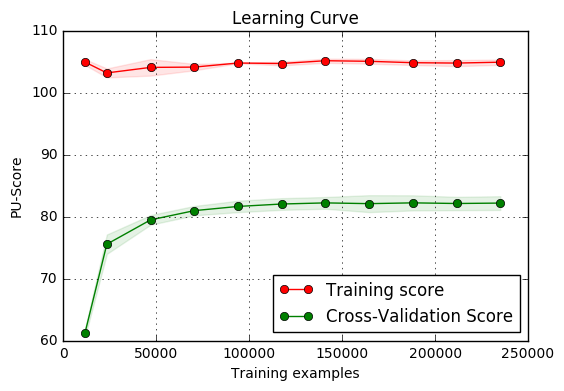

In [23]:
plt.figure()
plt.title('Learning Curve')
plt.xlabel("Training examples")
plt.ylabel("PU-Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
plt.legend(loc="best")

# Precision Recall curve for various thresholds used for Model #6

In [242]:
from sklearn.metrics import precision_recall_curve

In [249]:
labeled_probas = probas_df[probas_df.y_test >= 0]

In [250]:
pr, re, th = precision_recall_curve(labeled_probas.y_test, labeled_probas.probas, pos_label=1)

In [306]:
# find pr of unlabeled == pos
unlabeled_probas = probas_df[probas_df.y_test == -1].probas.values
total_unlabeled = len(unlabeled_probas)
pr_one_un = []
for thresh in th:
    p = sum(unlabeled_probas >= thresh)
    pr_one_un.append(p / total_unlabeled)
    print("{}:{} ".format(thresh, p/total_unlabeled))
pr_one_un.append(0.0)
pr_one_un = np.array(pr_one_un)

0.0019428540833625616:0.9712251591301267 
0.006416271426900016:0.9014478841692665 
0.010111305976965435:0.8528003474007794 
0.01226925457223538:0.828139463128664 
0.017313450995566148:0.7751151336464511 
0.019248508927969938:0.7561909332967648 
0.01987056506248012:0.7504771046887677 
0.021367881565321094:0.736352520369799 
0.027083647112230224:0.6875907070291519 
0.027090295485558854:0.687533568743072 
0.027345289321666223:0.6853051755859532 
0.02759095988475327:0.6833510462020181 
0.027772676039154294:0.6818654507639389 
0.02809738548245263:0.6791570960037483 
0.02907388442811063:0.6721176591586959 
0.02951963629280902:0.6687122173083296 
0.03201092761117261:0.6508279337652988 
0.032772067965003863:0.6449655456134937 
0.03426497885460726:0.6345320945752911 
0.03459112043228008:0.6323265567326043 
0.034621524785877586:0.6321094312455003 
0.03774263408808121:0.611402516370119 
0.03842731342731342:0.607391408687305 
0.039402092168527456:0.601483309906636 
0.03993508677903669:0.5981464339

In [358]:
def find_re_pr_prob(thresh):
    idx = np.nonzero(th >= thresh)[0][0]
    return re[idx], pr[idx], pr_one_un[idx]

In [398]:
re_50, pr_50, _ = find_re_pr_prob(0.5)
re_35, pr_35, _ = find_re_pr_prob(0.35)
re_40, pr_40, _ = find_re_pr_prob(0.4)
re_80, pr_80, _ = find_re_pr_prob(0.8)
re_20, pr_20, _ = find_re_pr_prob(0.2)

In [298]:
from matplotlib import cm, colors, colorbar

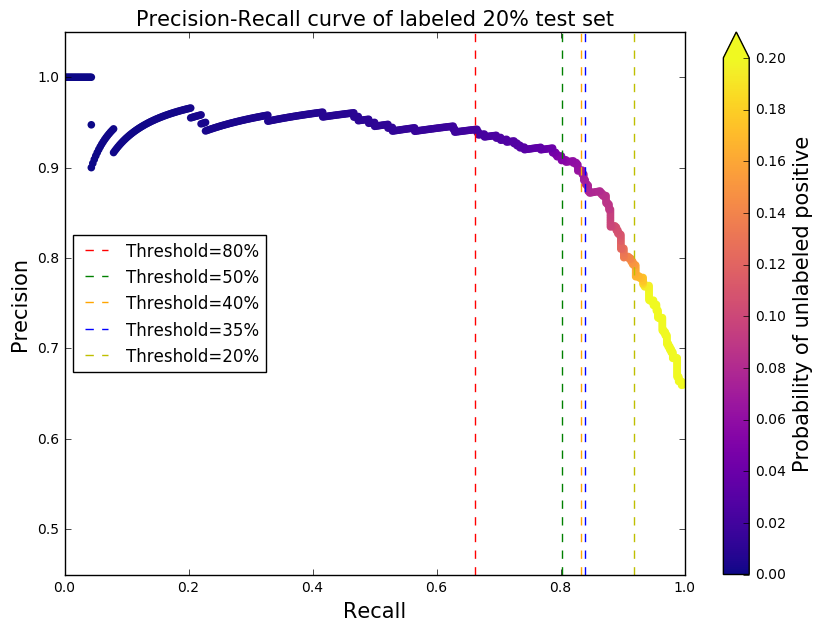

In [400]:
plt.clf()
plt.figure(figsize=(10, 7))
plt.xlabel('Recall', fontsize=15)
plt.xlim((0.0, 1.0))
plt.ylabel('Precision', fontsize=15)
plt.ylim((0.45, 1.05))
plt.title('Precision-Recall curve of labeled 20% test set', fontsize=15)
norm = colors.Normalize(vmin=0.0, vmax=0.2)
cmap = cm.plasma
plt.scatter(re, pr, c=pr_one_un, cmap=cmap, norm=norm, edgecolors='none', s=30)
#plt.scatter(re, pr, c=np.append(th, 1.0), cmap=cm.plasma, norm=norm)
cb = plt.colorbar(orientation='vertical', extend='max')
cb.set_label('Probability of unlabeled positive', fontsize=15)
plt.axvline(x=re_80, ls="--", c='r', label='Threshold=80%')
plt.axvline(x=re_50, ls="--", c='g', label='Threshold=50%')
plt.axvline(x=re_40, ls="--", c='orange', label='Threshold=40%')
plt.axvline(x=re_35, ls="--", c='b', label='Threshold=35%')
plt.axvline(x=re_20, ls="--", c='y', label='Threshold=20%')
plt.legend(loc='center left')
plt.show()